<font size = 7>DELE ST1504 CA2 Part B: Reinforcement Learning </font>
<hr>
<font size = 4>
Name: Lee Hong Yi & Yadanar Aung<br>
Admin No: 2223010 & <2214621><br>
Class: DAAA/FT/2B/07<br>
</font>
<hr>

**Objective:**  
Develop a model using a modified Deep Q-Network (DQN) architecture to balance a pendulum. The model should apply suitable torque to maintain the pendulum in an upright position. The primary focus is on demonstrating the effectiveness of the DQN in this context, with the possibility of exploring other reinforcement learning architectures after the successful implementation of DQN.

**Background:**  
Deep Q-Networks are a class of deep reinforcement learning algorithms that combine Q-Learning with deep neural networks. This project aims to apply DQN to the classic control problem of pendulum balancing, a benchmark challenge in the reinforcement learning field. The goal is to train a model that can learn the optimal strategy to keep the pendulum balanced by applying the correct amount of torque.

**Key Features:** <br>
Implement a modified version of the DQN algorithm to specifically address the dynamics of pendulum balancing, using the Pendulum environment from OpenAI Gym, which provides a standardized platform for testing the model's performance.

**Output Specification:**  
The output specification for this Deep Q-Network (DQN) project focused on balancing a pendulum entails the generation of control actions in the form of torque values, which are applied at each timestep to maintain the pendulum's upright position. These actions, derived from the model's learning process, will be complemented by performance metrics demonstrating the learning progression, such as episode duration, balance efficiency, and torque magnitude. Additionally, the model will provide visualizations of the pendulum's state and behavior over time, as well as detailed evaluation metrics like average reward per episode and loss over time. The final output includes the learned policy, represented either through model weights or a graphical depiction, showcasing the model's effectiveness in learning and applying the optimal strategy for pendulum balance.

<hr>
<font size = 5>Performing initial set-up</font>
<hr>

In [1]:
%load_ext autoreload
%autoreload 1
%aimport rlfunction

import gc
import gym
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython import display as ipythondisplay
from IPython.display import HTML
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import rlfunction as rlf

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)     
simplefilter(action='ignore', category=FutureWarning) 
simplefilter(action='ignore', category=DeprecationWarning)

sns.set_style();

In [3]:
# Fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(0)  

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    try:
        print(tf.config.experimental.get_device_details(gpu))
    except:
        pass
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPU(s) present.")

{'device_name': 'NVIDIA GeForce RTX 3060', 'compute_capability': (8, 6)}
There are 1 GPU(s) present.


In [5]:
sns.set_style('darkgrid')

In [6]:
import gym

# Initialize the environment with specified render mode
env = gym.make('Pendulum-v1', render_mode='rgb_array')
env.reset()
frames = []
reward_arr = []
for _ in range(50):
    action = env.action_space.sample()
    _, reward, _, *_ = env.step(action)
    reward_arr.append(reward)
    frame = env.render()
    frames.append(frame)

# Close the environment
env.close()

ani = rlf.create_animation(frames)
print(f"Reward for test episode (random): {np.mean(reward_arr)}")
HTML(ani.to_jshtml())
# display(ani)

Reward for test episode (random): -8.888030799672192


<hr>
<font size = 5>Exploratory Data Analysis (EDA)</font>
<hr>

action space is continuous (infinitie number of actions)
state space is continuous/discrete

<hr>
<font size = 5>Feature Engineering</font>
<hr>

<hr>
<font size = 5>Initial Modelling</font>
<hr>

saw said can use the code from lab 6, but there is something to fix so that it works for ca2.

dqn onyl good for discrete space. discretisize this env for dqn to work (put bins, e.g. 2 / 10 bins e.g. -1 to -1.6 is a bin)

no. of bins = no.s of actions

i lazy to do proper markdown 

In [29]:
# Discretize the action space
state_size = env.observation_space.shape[0]
num_discrete_actions = 20  # Example: 50 discrete actions
action_bounds = env.action_space.high[0]  # Assuming symmetric bounds
discrete_actions = np.linspace(-action_bounds, action_bounds, num_discrete_actions)

In [30]:
class dqn_template:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, memory_size=1000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.train_start = 1000
        self.memory = deque(maxlen = memory_size)
        self.reward_arr = []
        self.model = self.model_init(state_size, action_size)

    def model_init(self, state_size, action_size):
        model = Sequential()
        model.add(Dense(24, input_dim=state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model
    
    def prepare_training_data(self):
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([state[0] for state, _, _, _, _ in minibatch])
        targets = np.zeros((self.batch_size, num_discrete_actions))

        for i, (state, action_index, reward, next_state, done) in enumerate(minibatch):
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose = 0)[0])
            target_f = self.model.predict(state, verbose = 0)[0]
            target_f[action_index] = target
            targets[i] = target_f

        return states, targets
    
    def train(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        for episode in range(100):
            avg_score = []
            initial_state = env.reset()
            if isinstance(initial_state, tuple):
                state = initial_state[0]
            else:
                state = initial_state
            state = np.reshape(state, [1, self.state_size])
            for step in range(200):
                if np.random.rand() <= self.epsilon:
                    action_index = random.randrange(num_discrete_actions)
                else:
                    action_index = np.argmax(self.model.predict(state, verbose = 0)[0])
                action = [discrete_actions[action_index]]
                next_state, reward, _, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size]) 
                self.memory.append((state, action_index, reward, next_state, done))
                state = next_state
                avg_score.append(reward)
                # Training step
                if len(self.memory) > self.train_start:
                    states, targets = self.prepare_training_data()
                    with tf.GradientTape() as tape:
                        predictions = self.model(states)
                        loss = tf.keras.losses.MSE(targets, predictions)

                    gradients = tape.gradient(loss, self.model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                if done:
                    break
                if self.epsilon > self.epsilon_min and self.epsilon:
                    self.epsilon *= self.epsilon_decay

            print(f"Episode {episode + 1}: Average Reward: {np.mean(avg_score):.6f}, Epsilon: {self.epsilon:.6f}")
            self.reward_arr.append(np.mean(avg_score))
            gc.collect()

        return self.reward_arr

In [31]:
dqn_agent = dqn_template(state_size, num_discrete_actions, epsilon_decay = 0.99995, epsilon_min=0.02)
dqn_reward_arr = dqn_agent.train()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24)                96        
                                                                 
 dense_13 (Dense)            (None, 48)                1200      


                                                                 
 dense_14 (Dense)            (None, 48)                2352      
                                                                 
 dense_15 (Dense)            (None, 20)                980       
                                                                 
Total params: 4,628
Trainable params: 4,628
Non-trainable params: 0
_________________________________________________________________
Episode 1: Average Reward: -5.736742, Epsilon: 0.980296
Episode 2: Average Reward: -8.537436, Epsilon: 0.960980
Episode 3: Average Reward: -4.818718, Epsilon: 0.942044
Episode 4: Average Reward: -7.288996, Epsilon: 0.923482
Episode 5: Average Reward: -7.190463, Epsilon: 0.905285
Episode 6: Average Reward: -4.838050, Epsilon: 0.887447
Episode 7: Average Reward: -4.832812, Epsilon: 0.869961
Episode 8: Average Reward: -4.848900, Epsilon: 0.852819
Episode 9: Average Reward: -8.417577, Epsilon: 0.836015
Episode 10: Average Reward: -5.7

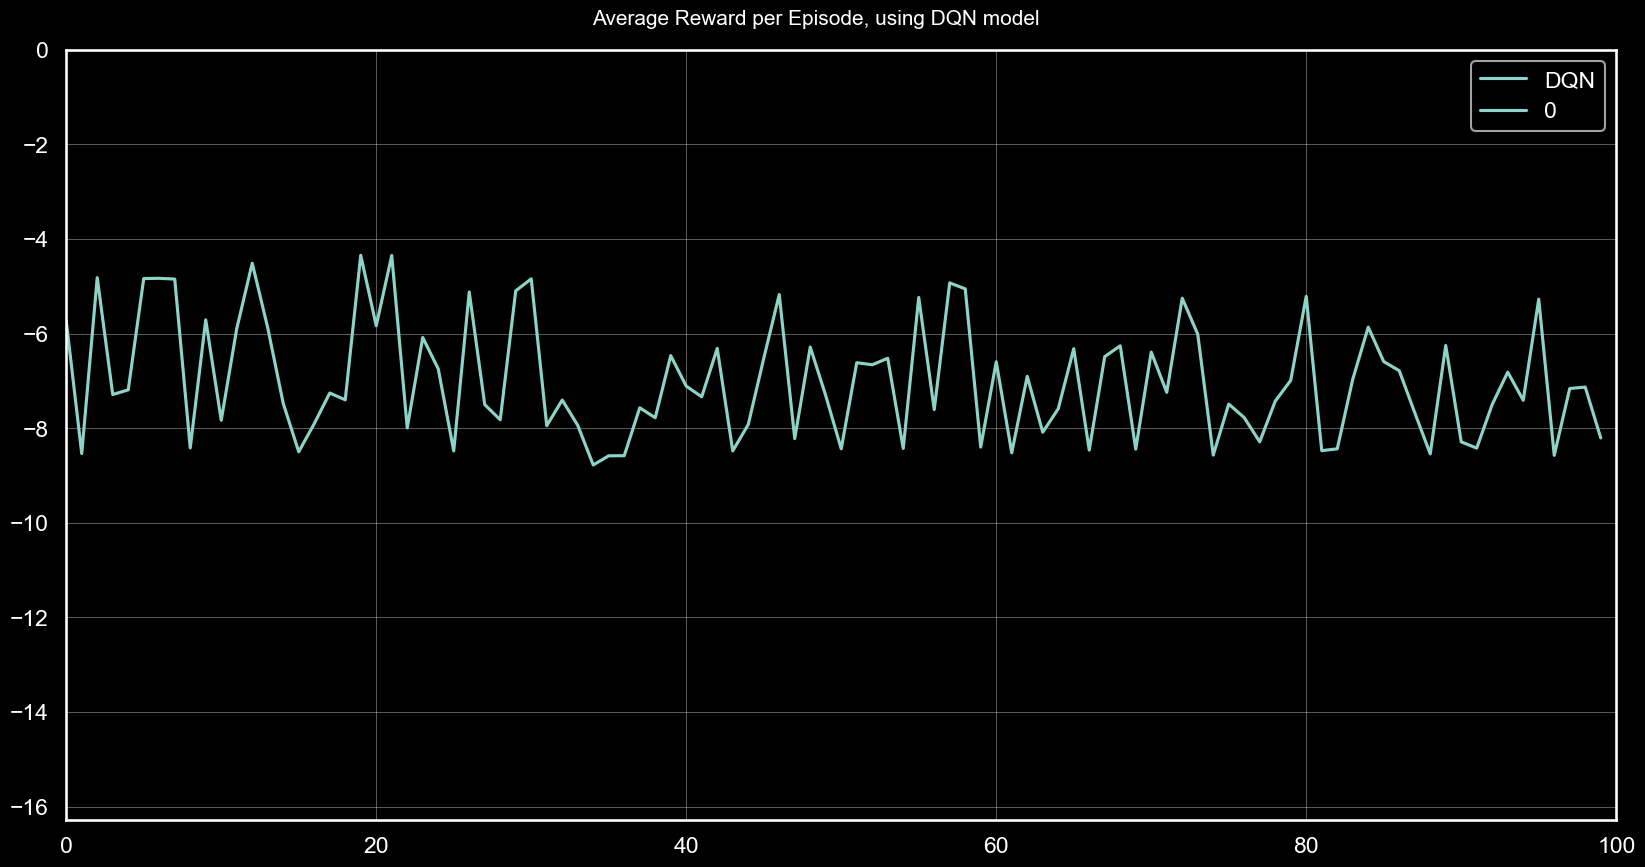

In [32]:
rlf.plot_results([dqn_reward_arr], ['DQN'], "DQN")

For this, we shall use more complicated models such as `Double DQN`, `Duelling DQN`, and `Rainbow`

In [33]:
rlf.env_viz(dqn_agent, state_size=state_size, discrete_actions=discrete_actions)

Average reward for test episode: -7.857748432384212


<hr>
<font size = 5>Model Improvement</font>
<hr>

<hr>
<font size = 5>Conclusion</font>
<hr>